In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

% matplotlib inline

from event_context import EventContext
import event_generation
import encoding_schemes
from event_schemas import BasicRNN
import hrr

Using TensorFlow backend.


## Event Schema Modeling

Because the encoding schemes translate scenes into vectors, any model that deals with vectors is a valid transition model. The objective of transition modeling is finding a model that can learn how scene vectors relate to each other; given a sequence of vectors representing scenes we've already seen, we want to predict the next one. We thus want a neural network architecture where the minimization of MSE (state error) leads to minimization of the decoded filler error. 

The main design decisions are the architecture of the neural network used and how we train the network on observed events. For the former decision, a wide range of possible architectures can be evaluated, where the only requirement is that the network can train and predict on sequences of scenes, representing events. 

The latter design decision can be approached 3 ways. The first is online learning, where the network is updated after each observed event. The second is a batch generalization with batch size > 1, where events falling under the event schema are not trained on until enough are seen. Finally we can train in windows or recall earlier events during training of a newly observed event to learn the events in a fine-grained manner while ensuring that the gradients are not too noisy; this requires a map between each event schema to the events assigned to it, representing memory consolidation. 

## State Representation Modeling

Basic structure of a scene has a subject, action, and object. For the sake of uniformity, property assignments occur within each scene, and do not constitute scenes in themselves; for instance, there aren't scenes like "Jerry becomes mad" or "Jerry is cold" because the assignment of abstract properties has a fundamentally different structure from action scenes. Instead the mad property can be incorporated as changes in the actor state; for instance the scene Jerry (not mad) loses money may lead to the scene Jerry (mad) hits table. While this yields a more uniform structure, there is the additional challenge of predicting both the change in actor properties due to actions and the chain of actions in a scene that depend on the actor state (in our example, the idea of "becoming mad" from "losing money" must be learned as an implicit intermediate step between "losing money" and "hitting table").

When measuring performance, we compare the decoded predicted vector with the ground truth fillers used to generate the vector. An important distinction when defining an error is whether we care about the getting the properties right, or whether the properties are just there to help decode the identity. For the sake of comparing different methods we just use the identity in this demo, but in future demos we will analyze performance of property prediction as well. We generate scenes using the following context.

In [2]:
def evaluate_predictions(encoding, events, fillers, context, is_training):
    # traverse all events
    avg_encoded_error = np.zeros(1)
    avg_decoded_error = np.zeros(3)
    for e in range(len(events)):
        seen = [events[e][0]]
        event_encoded_error = np.zeros(1)
        event_decoded_error = np.zeros(3)
        # traverse all scenes excluding the first
        for s in range(1, len(events[e])):
            prediction = hrr.normalize(transition_model.predict(seen))
            event_encoded_error += np.linalg.norm(events[e][s] - prediction)/(len(events[e]) - 1)
            event_decoded_error += np.asarray(encoding_schemes.filler_errors(encoding, prediction, fillers[e][s], context, is_training))/(len(events[e]) - 1)
            seen.append(events[e][s])
        avg_encoded_error += event_encoded_error/len(events)
        avg_decoded_error += event_decoded_error/len(events)
    return [event_encoded_error, event_decoded_error]
                
def train_and_evaluate(context, encoding, train_size, eval_size, transition_model):
    training, training_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = train_size, testing = False)
    train_decoded_errors = []
    test_decoded_errors = []
    train_encoded_errors = []
    test_encoded_errors = []
    for e in range(len(training)):
        transition_model.train_recurrent(list(map(lambda x : hrr.normalize(x), training[e])))
        if e % 100 == 0:
            train_eval, train_eval_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = False)
            train_errors = evaluate_predictions(encoding, train_eval, train_eval_fillers, context, True)
            train_encoded_errors.append(train_errors[0])
            train_decoded_errors.append(train_errors[1])

            test_eval, test_eval_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = True)
            test_errors = evaluate_predictions(encoding, test_eval, test_eval_fillers, context, False)
            test_encoded_errors.append(test_errors[0])
            test_decoded_errors.append(test_errors[1])
    errors = {}
    errors['train_decoded_errors'] = np.asarray(train_decoded_errors)
    errors['train_encoded_errors'] = np.asarray(train_encoded_errors)
    errors['test_decoded_errors'] = np.asarray(test_decoded_errors)
    errors['test_encoded_errors'] = np.asarray(test_encoded_errors)
    return errors

In [3]:
def batch_evaluate(context, encoding, train_batches, train_batch_size, eval_size, transition_model):
    train_decoded_errors = []
    test_decoded_errors = []
    train_encoded_errors = []
    test_encoded_errors = []
    
    for i in range(train_batches):
        training, training_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = train_batch_size, testing = False)
        X = list(map(lambda x: x[0:len(x) - 1], training))
        Y = list(map(lambda x: x[1:len(x)], training))
        
        for k in range(1):
            for j in range(min(list(map(lambda x: len(x), X))), max(list(map(lambda x: len(x), X))) + 1):
                ind = [i for i, x in enumerate(X) if len(x) == j]
                if len(ind) == 0 or len(ind) == 1:
                    continue
                X_L = [x for x in X if len(x) == j]
                Y_L = [y for y in Y if len(y) == j]
                transition_model.model.fit(X_L, Y_L, batch_size = len(ind), epochs=3, verbose=0)
        train_eval, train_eval_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = False)
        train_errors = evaluate_predictions(encoding, train_eval, train_eval_fillers, context, True)
        train_encoded_errors.append(train_errors[0])
        train_decoded_errors.append(train_errors[1])

        test_eval, test_eval_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = True)
        test_errors = evaluate_predictions(encoding, test_eval, test_eval_fillers, context, False)
        test_encoded_errors.append(test_errors[0])
        test_decoded_errors.append(test_errors[1])
    errors = {}
    errors['train_decoded_errors'] = np.asarray(train_decoded_errors)
    errors['train_encoded_errors'] = np.asarray(train_encoded_errors)
    errors['test_decoded_errors'] = np.asarray(test_decoded_errors)
    errors['test_encoded_errors'] = np.asarray(test_encoded_errors)
    return errors

In [4]:
properties = ['thirsty', 'violent', 'impatient', 'rich']
nouns = ['coffeeshop', 'coffee', 'line', 'store', 'shirt', 'mall']
verbs = ['enter', 'obey', 'cut', 'buy', 'confront', 'hit', 'apologize', 'leave', 'greet', 'try']

dim = 150
train_size = 5000
eval_size = 100
context = EventContext(dim, nouns, verbs, properties, num_train_actors = 20, num_test_actors = 7)

batch_num = 100
batch_size = 20

layers = [(30, 'sigmoid'), (dim, 'linear')]

#### Baseline Model

A baseline of subject identity, action identity, object identity will be used to check how much of an improvement different property encoding methods yield. The way in which we incorporate properties is a crucial problem for encoding. Because properties determine the event transitions, we predict that without incorporating properties the testing error will not decrease for any field, representing the inability to generalize across fillers.

In [5]:
transition_model = BasicRNN(dim, layers = layers)
encoding = 'baseline'
baseline_errors = batch_evaluate(context, encoding, batch_num, batch_size, eval_size, transition_model)

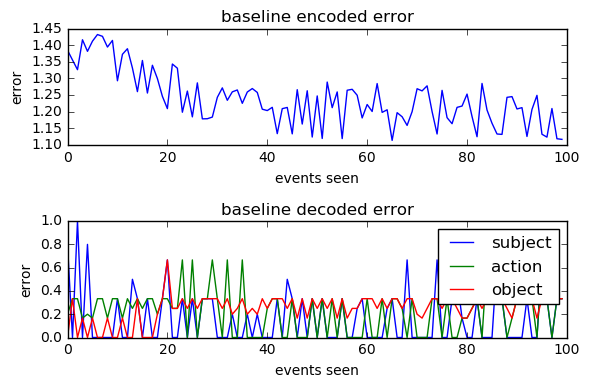

In [6]:
plt.subplot(2, 1, 1)
plt.plot(range(batch_num), baseline_errors['test_encoded_errors'])
plt.title("baseline encoded error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.subplot(2, 1, 2)
plt.plot(range(batch_num), baseline_errors['test_decoded_errors'][:,0], label = "subject")
plt.plot(range(batch_num), baseline_errors['test_decoded_errors'][:,1], label = "action")
plt.plot(range(batch_num), baseline_errors['test_decoded_errors'][:,2], label = "object")
plt.legend()
plt.title("baseline decoded error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.tight_layout()
plt.show()

#### Selective Property Addition

Only the properties that determine the underlying transition dynamics are included, representing prior knowledge of what properties to focus on. This is not immediately plausible in learning transition dynamics as it employs circular reasoning, but it serves as a best case benchmark due to its lack of noise.

In the additive model the properties of an object are added with the identity vector of that object.

In [7]:
transition_model = BasicRNN(dim, layers = layers)
encoding = 'selective_property_addition'
selective_property_addition_errors = batch_evaluate(context, encoding, batch_num, batch_size, eval_size, transition_model)

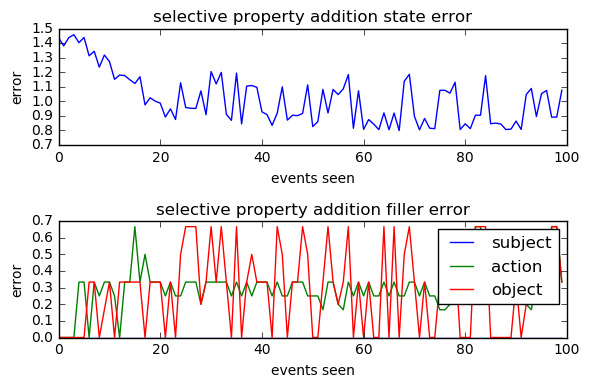

In [8]:
plt.subplot(2, 1, 1)
plt.plot(range(batch_num), selective_property_addition_errors['test_encoded_errors'])
plt.title("selective property addition state error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.subplot(2, 1, 2)
plt.plot(range(batch_num), selective_property_addition_errors['test_decoded_errors'][:,0], label = "subject")
plt.plot(range(batch_num), selective_property_addition_errors['test_decoded_errors'][:,1], label = "action")
plt.plot(range(batch_num), selective_property_addition_errors['test_decoded_errors'][:,2], label = "object")
plt.legend()
plt.title("selective property addition filler error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.tight_layout()
plt.show()

#### Selective Property Binding

Only the properties that determine the underlying transition dynamics are included, representing prior knowledge of what properties to focus on. This is not immediately plausible in learning transition dynamics as it employs circular reasoning, but it serves as a best case benchmark due to its lack of noise.

In the binding model the properties of an object are bound with a property role; this memory trace is added to the memory trace by binding the object identity with a noun role to form either the agent or the patient filler. A null property role is used for actors without any properties.

In [9]:
transition_model = BasicRNN(dim, layers = layers)
encoding = 'selective_property_binding'
selective_property_binding_errors = batch_evaluate(context, encoding, batch_num, batch_size, eval_size, transition_model)

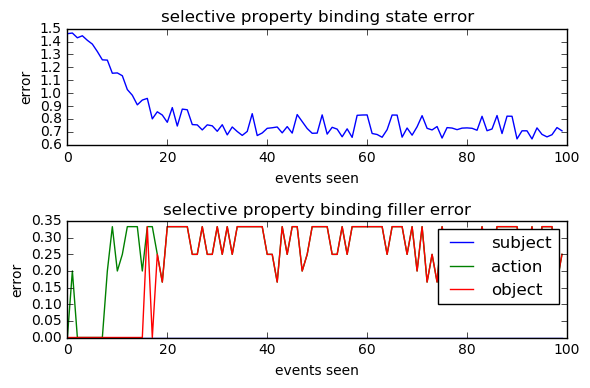

In [10]:
plt.subplot(2, 1, 1)
plt.plot(range(batch_num), selective_property_binding_errors['test_encoded_errors'])
plt.title("selective property binding state error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.subplot(2, 1, 2)
plt.plot(range(batch_num), selective_property_binding_errors['test_decoded_errors'][:,0], label = "subject")
plt.plot(range(batch_num), selective_property_binding_errors['test_decoded_errors'][:,1], label = "action")
plt.plot(range(batch_num), selective_property_binding_errors['test_decoded_errors'][:,2], label = "object")
plt.legend()
plt.title("selective property binding filler error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.tight_layout()
plt.show()

#### All Property Addition

All properties of an actor to ensure that sufficient information for transitions is included. We hope that the event schemas can learn which properties contribute to the transition dynamics.

In the additive model the properties of an object are added with the identity vector of that object.

In [11]:
transition_model = BasicRNN(dim, layers = layers)
encoding = 'all_property_addition'
all_property_addition_errors = batch_evaluate(context, encoding, batch_num, batch_size, eval_size, transition_model)

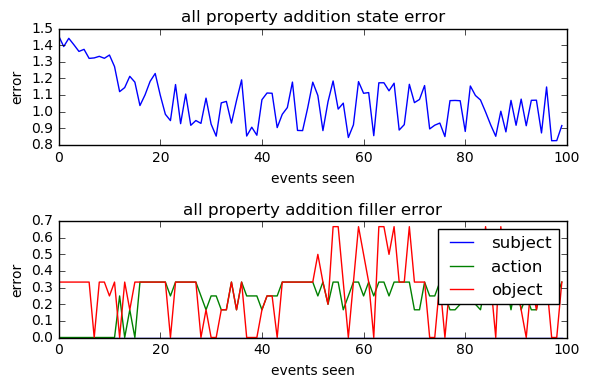

In [12]:
plt.subplot(2, 1, 1)
plt.plot(range(batch_num), all_property_addition_errors['test_encoded_errors'])
plt.title("all property addition state error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.subplot(2, 1, 2)
plt.plot(range(batch_num), all_property_addition_errors['test_decoded_errors'][:,0], label = "subject")
plt.plot(range(batch_num), all_property_addition_errors['test_decoded_errors'][:,1], label = "action")
plt.plot(range(batch_num), all_property_addition_errors['test_decoded_errors'][:,2], label = "object")
plt.legend()
plt.title("all property addition filler error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.tight_layout()
plt.show()

#### All Property Binding

All properties of an actor to ensure that sufficient information for transitions is included. We hope that the event schemas can learn which properties contribute to the transition dynamics.

In the binding model each property in the filler pool is bound with either an isTrue role or an isFalse role depending on whether the actor possesses the property, the actor identity is bound with an identity role, and all of the memory traces are added together.

In [13]:
transition_model = BasicRNN(dim, layers = layers)
encoding = 'all_property_binding'
all_property_binding_errors = batch_evaluate(context, encoding, batch_num, batch_size, eval_size, transition_model)

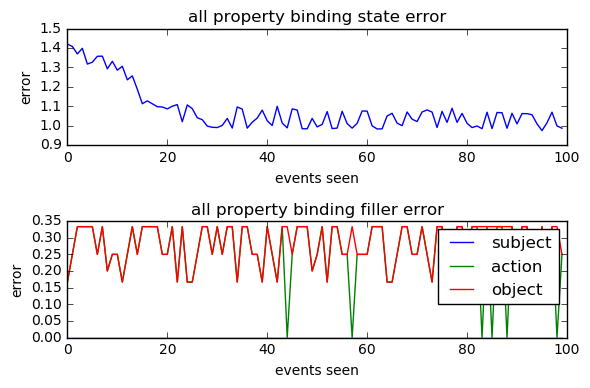

In [14]:
plt.subplot(2, 1, 1)
plt.plot(range(batch_num), all_property_binding_errors['test_encoded_errors'])
plt.title("all property binding state error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.subplot(2, 1, 2)
plt.plot(range(batch_num), all_property_binding_errors['test_decoded_errors'][:,0], label = "subject")
plt.plot(range(batch_num), all_property_binding_errors['test_decoded_errors'][:,1], label = "action")
plt.plot(range(batch_num), all_property_binding_errors['test_decoded_errors'][:,2], label = "object")
plt.legend()
plt.title("all property binding filler error")
plt.xlabel("events seen")
plt.ylabel("error")
plt.tight_layout()
plt.show()

#### Model Comparison: Encoded Error

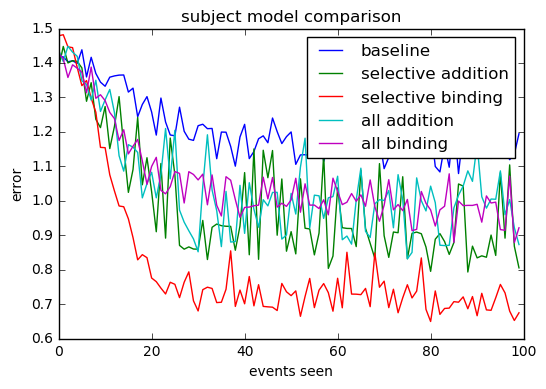

In [16]:
plt.plot(range(batch_num), baseline_errors['train_encoded_errors'][:,0], label = "baseline")
plt.plot(range(batch_num), selective_property_addition_errors['train_encoded_errors'][:,0], label = "selective addition")
plt.plot(range(batch_num), selective_property_binding_errors['train_encoded_errors'][:,0], label = "selective binding")
plt.plot(range(batch_num), all_property_addition_errors['train_encoded_errors'][:,0], label = "all addition")
plt.plot(range(batch_num), all_property_binding_errors['train_encoded_errors'][:,0], label = "all binding")
plt.legend()
plt.title("subject model comparison")
plt.xlabel("events seen")
plt.ylabel("error")

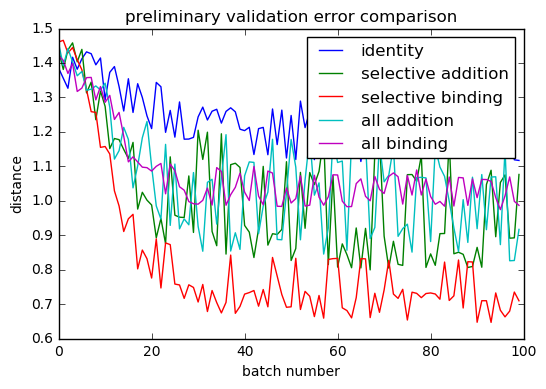

In [17]:
plt.plot(range(batch_num), baseline_errors['test_encoded_errors'][:,0], label = "identity")
plt.plot(range(batch_num), selective_property_addition_errors['test_encoded_errors'][:,0], label = "selective addition")
plt.plot(range(batch_num), selective_property_binding_errors['test_encoded_errors'][:,0], label = "selective binding")
plt.plot(range(batch_num), all_property_addition_errors['test_encoded_errors'][:,0], label = "all addition")
plt.plot(range(batch_num), all_property_binding_errors['test_encoded_errors'][:,0], label = "all binding")
plt.legend()
plt.title("preliminary validation error comparison")
plt.xlabel("batch number")
plt.ylabel("distance")

#### Model Comparison: Decoded Error

(0, 1)

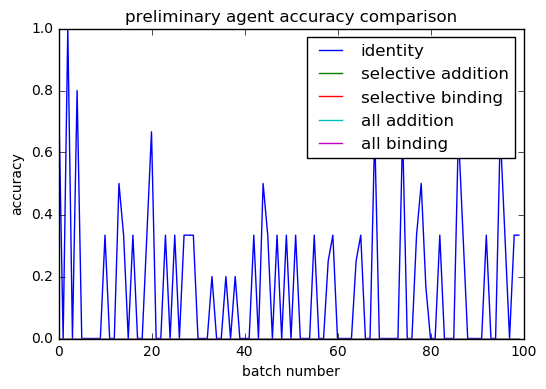

In [18]:
plt.plot(range(batch_num), baseline_errors['test_decoded_errors'][:,0], label = "identity")
plt.plot(range(batch_num), selective_property_addition_errors['test_decoded_errors'][:,0], label = "selective addition")
plt.plot(range(batch_num), selective_property_binding_errors['test_decoded_errors'][:,0], label = "selective binding")
plt.plot(range(batch_num), all_property_addition_errors['test_decoded_errors'][:,0], label = "all addition")
plt.plot(range(batch_num), all_property_binding_errors['test_decoded_errors'][:,0], label = "all binding")
plt.legend()
plt.title("preliminary agent accuracy comparison")
plt.xlabel("batch number")
plt.ylabel("accuracy")
plt.ylim(0,1)

(0, 1)

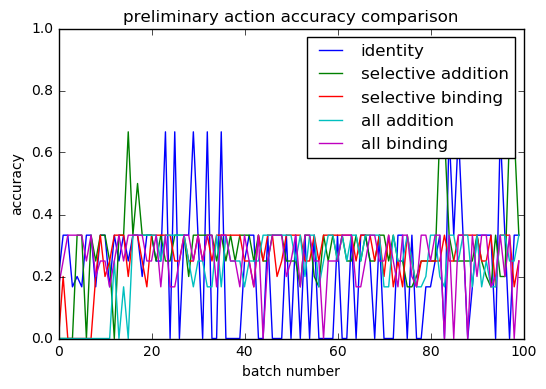

In [19]:
plt.plot(range(batch_num), baseline_errors['test_decoded_errors'][:,1], label = "identity")
plt.plot(range(batch_num), selective_property_addition_errors['test_decoded_errors'][:,1], label = "selective addition")
plt.plot(range(batch_num), selective_property_binding_errors['test_decoded_errors'][:,1], label = "selective binding")
plt.plot(range(batch_num), all_property_addition_errors['test_decoded_errors'][:,1], label = "all addition")
plt.plot(range(batch_num), all_property_binding_errors['test_decoded_errors'][:,1], label = "all binding")
plt.legend()
plt.title("preliminary action accuracy comparison")
plt.xlabel("batch number")
plt.ylabel("accuracy")
plt.ylim(0,1)

(0, 1)

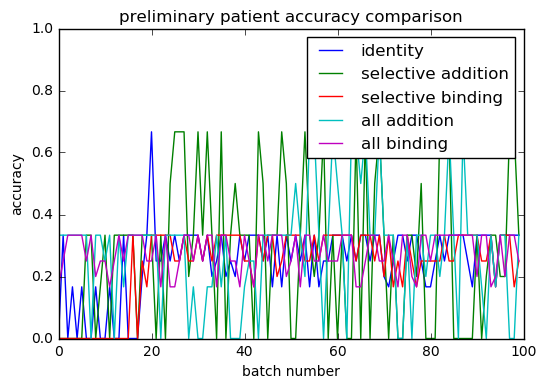

In [20]:
plt.plot(range(batch_num), baseline_errors['test_decoded_errors'][:,2], label = "identity")
plt.plot(range(batch_num), selective_property_addition_errors['test_decoded_errors'][:,2], label = "selective addition")
plt.plot(range(batch_num), selective_property_binding_errors['test_decoded_errors'][:,2], label = "selective binding")
plt.plot(range(batch_num), all_property_addition_errors['test_decoded_errors'][:,2], label = "all addition")
plt.plot(range(batch_num), all_property_binding_errors['test_decoded_errors'][:,2], label = "all binding")
plt.legend()
plt.title("preliminary patient accuracy comparison")
plt.xlabel("batch number")
plt.ylabel("accuracy")
plt.ylim(0,1)